## tasks
### 1: Form training and testing periods as discussed (2 test periods, last 2*365 days). Be careful tp scale data only based on data from the training set. You may use (from Python) MinMaxScaler, standardisation (StandardScaler) or the default scaler in Python's elastic net.
### 2:Estimate the current flu rates by training an elastic net model. Use a Pearson correlation filter (r > 0.3) on the training data to reduce the amount of queries prior to training an elastic net (reminder: not all 1000 queries I provided are related to flu!). Report performance on the two test sets using three metrics: mean absolute error, root mean squared error and Pearson's correlation.
### 3: If there is time, begin work on traditional forecasting models (you've identified seasonal ARIMA and Hult-Winters).

In [16]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (10, 10)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 250 queries
X = X.iloc[:, 0: 250]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 250)   y shape:  (4383, 1)
train1 X: (3618, 250)  train1 y: (3618, 1)  Test1 X shape: (365, 250)  Test1 y shape: (365, 1)
validation1 X: (400, 250)  validation1 y: (400, 1)
train2 X: (3293, 250)  train2 y: (3293, 1)  Test2 X: (365, 250)  Test2 y: (365, 1)
validation2 X: (360, 250)  validation2 y: (360, 1)


In [5]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [6]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,250):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [7]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [8]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  149


In [9]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def eNet(a,l,train_X,train_y,test_X,test_y):
    alpha = a
    l1_ratio = l
    enet = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
    enet.fit(train_X,train_y)
    print('Nonzero weights: %d from %d' % (len(np.nonzero(enet.coef_)[0]), len(enet.coef_)))
    y_pred1 = enet.predict(test_X)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
    


# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [11]:
## Fixing l1-ratio = 0.3, only tuning alpha.
para = range(1,300)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train1_X1,train1_y,val1_X1,val1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')
        

For correlation filter r>=0.2, 212 features are selected
alpha: 1  L1-ratio: 0.3
Nonzero weights: 134 from 149
Best RMSE is updated! 
The mean absolute error is:  22.57108080490069
The root mean squared error is:  45.30798076932783
The correlation is:  0.7657237018654257
----------------------------------------
alpha: 2  L1-ratio: 0.3
Nonzero weights: 115 from 149
Best RMSE is updated! 
The mean absolute error is:  22.205842320280343
The root mean squared error is:  43.950095134564094
The correlation is:  0.7863692235612229
----------------------------------------
alpha: 3  L1-ratio: 0.3
Nonzero weights: 104 from 149
Best RMSE is updated! 
The mean absolute error is:  21.564109215720165
The root mean squared error is:  42.26098730905937
The correlation is:  0.8041432464502939
----------------------------------------
alpha: 4  L1-ratio: 0.3
Nonzero weights: 92 from 149
Best RMSE is updated! 
The mean absolute error is:  21.117164604253393
The root mean squared error is:  41.008986042569

Nonzero weights: 18 from 149
Best RMSE is updated! 
The mean absolute error is:  18.26796316559279
The root mean squared error is:  33.211754985326785
The correlation is:  0.9197241894291124
----------------------------------------
alpha: 56  L1-ratio: 0.3
Nonzero weights: 18 from 149
Best RMSE is updated! 
The mean absolute error is:  18.24686639207382
The root mean squared error is:  33.16058090016439
The correlation is:  0.9201457448011157
----------------------------------------
alpha: 57  L1-ratio: 0.3
Nonzero weights: 17 from 149
Best RMSE is updated! 
The mean absolute error is:  18.16977199207104
The root mean squared error is:  32.9951527940168
The correlation is:  0.9206713296576928
----------------------------------------
alpha: 58  L1-ratio: 0.3
Nonzero weights: 17 from 149
Best RMSE is updated! 
The mean absolute error is:  18.07926905426787
The root mean squared error is:  32.80133666804583
The correlation is:  0.9211321402871468
----------------------------------------
a

Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  15.828831776515372
The root mean squared error is:  27.982476233952948
The correlation is:  0.929232296178304
----------------------------------------
alpha: 91  L1-ratio: 0.3
Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  15.776251234391939
The root mean squared error is:  27.86604649968629
The correlation is:  0.9293141540262982
----------------------------------------
alpha: 92  L1-ratio: 0.3
Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  15.728004291094145
The root mean squared error is:  27.758142489326026
The correlation is:  0.9293748198833541
----------------------------------------
alpha: 93  L1-ratio: 0.3
Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  15.678688438161341
The root mean squared error is:  27.64830615810564
The correlation is:  0.9294386402229918
----------------------------------------


Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  14.254894604766125
The root mean squared error is:  24.60415239641018
The correlation is:  0.930838611105195
----------------------------------------
alpha: 121  L1-ratio: 0.3
Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  14.200018045061515
The root mean squared error is:  24.491113184159264
The correlation is:  0.9308661259200877
----------------------------------------
alpha: 122  L1-ratio: 0.3
Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  14.147530354891867
The root mean squared error is:  24.382562978956084
The correlation is:  0.9308829381912902
----------------------------------------
alpha: 123  L1-ratio: 0.3
Nonzero weights: 9 from 149
Best RMSE is updated! 
The mean absolute error is:  14.094780934529602
The root mean squared error is:  24.2738859172152
The correlation is:  0.9308978496120409
---------------------------------------

Nonzero weights: 7 from 149
Best RMSE is updated! 
The mean absolute error is:  12.809494929791615
The root mean squared error is:  21.736423072817978
The correlation is:  0.9306063999122252
----------------------------------------
alpha: 152  L1-ratio: 0.3
Nonzero weights: 7 from 149
Best RMSE is updated! 
The mean absolute error is:  12.773822591392024
The root mean squared error is:  21.673149769069024
The correlation is:  0.9306478069150897
----------------------------------------
alpha: 153  L1-ratio: 0.3
Nonzero weights: 7 from 149
Best RMSE is updated! 
The mean absolute error is:  12.738182275067825
The root mean squared error is:  21.610160860202217
The correlation is:  0.9306867921472635
----------------------------------------
alpha: 154  L1-ratio: 0.3
Nonzero weights: 7 from 149
Best RMSE is updated! 
The mean absolute error is:  12.702584180705141
The root mean squared error is:  21.547473655919763
The correlation is:  0.9307233270647991
-----------------------------------

Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.831923189652588
The root mean squared error is:  20.079704057164275
The correlation is:  0.9309373188385057
----------------------------------------
alpha: 182  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.803283731886868
The root mean squared error is:  20.02939427432183
The correlation is:  0.9309172842527209
----------------------------------------
alpha: 183  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.776601640239733
The root mean squared error is:  19.979293963017973
The correlation is:  0.930895184087817
----------------------------------------
alpha: 184  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.752292529753179
The root mean squared error is:  19.92941303709236
The correlation is:  0.9308710062611593
--------------------------------------

Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.145839558623925
The root mean squared error is:  18.596532851502413
The correlation is:  0.9292305866586582
----------------------------------------
alpha: 214  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.129011754600478
The root mean squared error is:  18.554667171842095
The correlation is:  0.9291404067315492
----------------------------------------
alpha: 215  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.112198977126479
The root mean squared error is:  18.51308399248633
The correlation is:  0.929047905078071
----------------------------------------
alpha: 216  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  11.095401208881103
The root mean squared error is:  18.471784207428566
The correlation is:  0.9289530740137647
-------------------------------------

Nonzero weights: 4 from 149
alpha: 250  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 251  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 252  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 253  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 254  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 255  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 256  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 257  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 258  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 259  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 260  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 261  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 262  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 263  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 264  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 265  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 266  L1-ratio: 0.3
Nonzero weights: 4 from 149
alpha: 267  L1-ratio: 0.3
Nonzero weights: 4 from 149


In [12]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 149) (400, 149)


((4018, 149), (4018, 1))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [13]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [243]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train3_X,train3_y,test1_X1,test1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 243  L1-ratio: 0.3
Nonzero weights: 6 from 149
Best RMSE is updated! 
The mean absolute error is:  3.4989568739848136
The root mean squared error is:  4.01903742365115
The correlation is:  0.8258315058486163
----------------------------------------


In [14]:

enet = ElasticNet(alpha=243, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train3_X,train3_y)

y_pred1 = enet.predict(test1_X1)
    

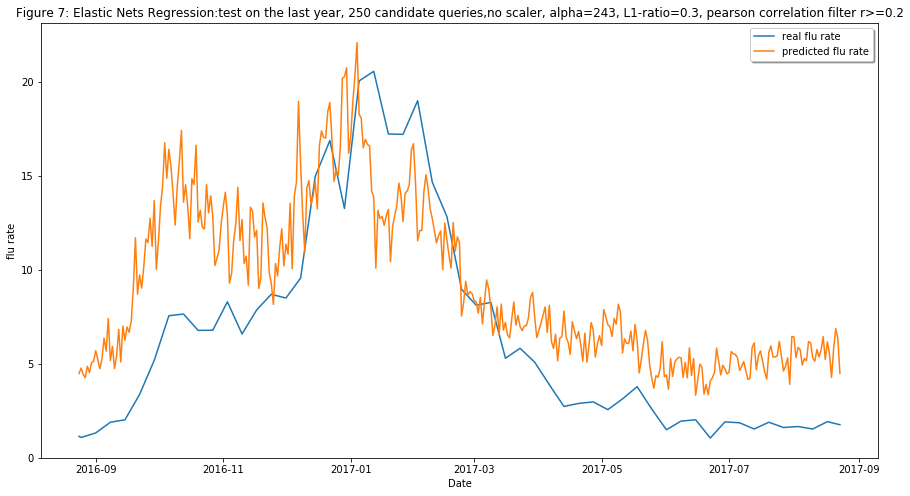

In [17]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 7: Elastic Nets Regression:test on the last year, 250 candidate queries,no scaler, alpha=243, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [19]:

train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [20]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [21]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  163


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

In [22]:
para = range(1,100)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.1, 303 features are selected
alpha: 1  L1-ratio: 0.3
Nonzero weights: 148 from 163
Best RMSE is updated! 
The mean absolute error is:  4.180929211103643
The root mean squared error is:  7.6779995833041434
The correlation is:  0.5018221715819583
----------------------------------------
alpha: 2  L1-ratio: 0.3
Nonzero weights: 136 from 163
alpha: 3  L1-ratio: 0.3
Nonzero weights: 122 from 163
alpha: 4  L1-ratio: 0.3
Nonzero weights: 106 from 163
alpha: 5  L1-ratio: 0.3
Nonzero weights: 101 from 163
alpha: 6  L1-ratio: 0.3
Nonzero weights: 94 from 163
Best RMSE is updated! 
The mean absolute error is:  4.07992066191083
The root mean squared error is:  7.449623310499454
The correlation is:  0.49595532182456403
----------------------------------------
alpha: 7  L1-ratio: 0.3
Nonzero weights: 89 from 163
Best RMSE is updated! 
The mean absolute error is:  4.013038714674817
The root mean squared error is:  7.22219047653367
The correlation is:  0.5093407002237039
--

Nonzero weights: 39 from 163
Best RMSE is updated! 
The mean absolute error is:  3.6500617205058914
The root mean squared error is:  6.010843899313508
The correlation is:  0.6091819806090132
----------------------------------------
alpha: 34  L1-ratio: 0.3
Nonzero weights: 38 from 163
Best RMSE is updated! 
The mean absolute error is:  3.6483245235997566
The root mean squared error is:  6.009109023899266
The correlation is:  0.6093935810815184
----------------------------------------
alpha: 35  L1-ratio: 0.3
Nonzero weights: 37 from 163
alpha: 36  L1-ratio: 0.3
Nonzero weights: 37 from 163
alpha: 37  L1-ratio: 0.3
Nonzero weights: 37 from 163
alpha: 38  L1-ratio: 0.3
Nonzero weights: 36 from 163
alpha: 39  L1-ratio: 0.3
Nonzero weights: 36 from 163
alpha: 40  L1-ratio: 0.3
Nonzero weights: 35 from 163
alpha: 41  L1-ratio: 0.3
Nonzero weights: 35 from 163
alpha: 42  L1-ratio: 0.3
Nonzero weights: 32 from 163
alpha: 43  L1-ratio: 0.3
Nonzero weights: 32 from 163
alpha: 44  L1-ratio: 0.3


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [23]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 163) (360, 163)


((3653, 163), (3653, 1))

In [24]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [34]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train4_X,train4_y,test2_X1,test2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 34  L1-ratio: 0.3
Nonzero weights: 39 from 163
Best RMSE is updated! 
The mean absolute error is:  2.739359566693404
The root mean squared error is:  3.382176110725836
The correlation is:  0.9069384826023859
----------------------------------------


In [25]:
enet = ElasticNet(alpha=34, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train4_X,train4_y)

y_pred2 = enet.predict(test2_X1)

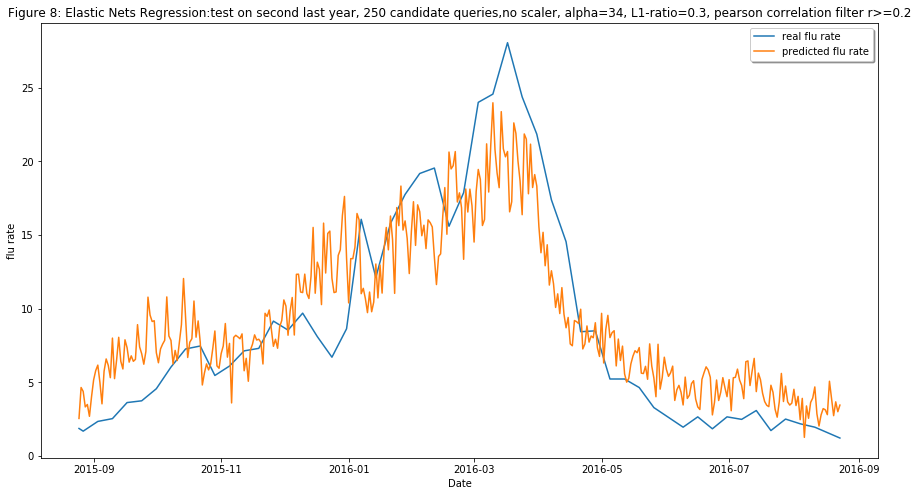

In [27]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 8: Elastic Nets Regression:test on second last year, 250 candidate queries,no scaler, alpha=34, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()